In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
import pickle
import gzip

df = pd.read_csv('../Data/Border_Crossing_Entry_Data.csv')
df.head()





,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Roma,Texas,2310,US-Mexico Border,Dec 2023,Buses,46,26.404,-99.019,POINT (-99.018981 26.403928)
1,Del Rio,Texas,2302,US-Mexico Border,Dec 2023,Trucks,6552,29.327,-100.928,POINT (-100.927612 29.326784)
2,Roma,Texas,2310,US-Mexico Border,Nov 2023,Trucks,3753,26.404,-99.019,POINT (-99.018981 26.403928)
3,Douglas,Arizona,2601,US-Mexico Border,Oct 2023,Buses,13,31.334,-109.560,POINT (-109.560344 31.334043)
4,Beecher Falls,Vermont,206,US-Canada Border,Aug 2023,Trucks,422,45.013,-71.505,POINT (-71.505309 45.013411)


In [402]:
# convert String date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Port Name'].nunique()


116

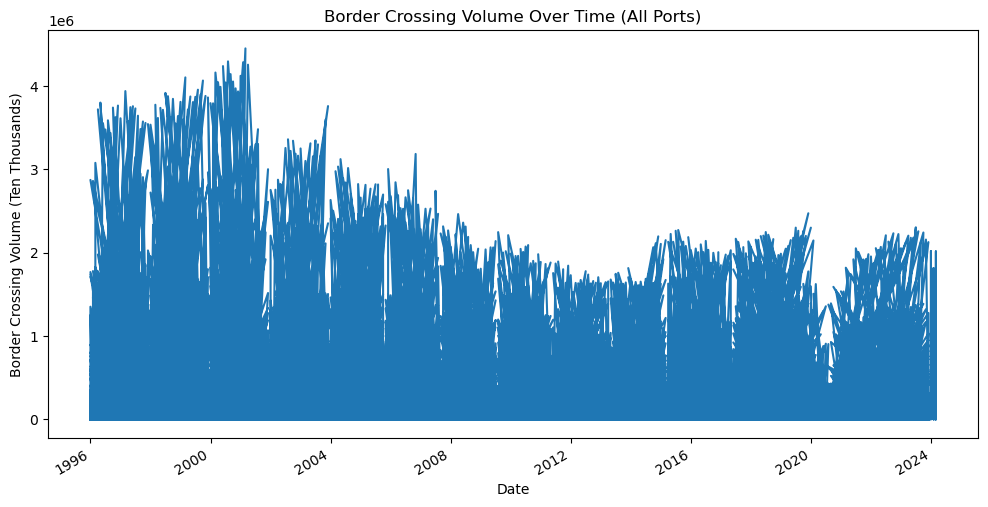

In [403]:
# plotting border crossing volume over time
plt.figure(figsize=(12, 6))
df.set_index('Date')['Value'].plot()
plt.title('Border Crossing Volume Over Time (All Ports)')
plt.xlabel('Date')
plt.ylabel('Border Crossing Volume (Ten Thousands)')
plt.show()

### Feature Engineering

In [404]:

lags = [1, 7, 30, 365]  # lag periods (in days)
for lag in lags:
    df[f'Latitude_Lag_{lag}'] = df['Latitude'].shift(lag)
    df[f'Longitude_Lag_{lag}'] = df['Longitude'].shift(lag)

In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391043 entries, 0 to 391042
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Port Name          391043 non-null  object        
 1   State              391043 non-null  object        
 2   Port Code          391043 non-null  int64         
 3   Border             391043 non-null  object        
 4   Date               391043 non-null  datetime64[ns]
 5   Measure            391043 non-null  object        
 6   Value              391043 non-null  int64         
 7   Latitude           391043 non-null  float64       
 8   Longitude          391043 non-null  float64       
 9   Point              391043 non-null  object        
 10  Latitude_Lag_1     391042 non-null  float64       
 11  Longitude_Lag_1    391042 non-null  float64       
 12  Latitude_Lag_7     391036 non-null  float64       
 13  Longitude_Lag_7    391036 non-null  float64 

In [406]:
df.isnull().sum()
df.dropna(inplace=True)

### Model Training

In [407]:
features = ['Latitude', 'Longitude', 'Date', 'Latitude_Lag_1', 'Longitude_Lag_1']
target = 'Value'

train_data = df[df['Date'] < '2022-01-01']  
test_data = df[df['Date'] >= '2022-01-01']  

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (370532, 5) (370532,)
Testing set shape: (20146, 5) (20146,)


In [408]:
# Fit Arima Model for Sumas Port

train_sumas_data = train_data[train_data['Port Name'] == 'Sumas']
y_train_sumas = train_sumas_data[target]

order = (1, 0, 0)  # (p, d, q)
model = ARIMA(y_train_sumas, order=order)
trained_model = model.fit()


test_sumas_data = test_data[test_data['Port Name'] == 'Sumas']
y_test_sumas = test_sumas_data[target]
forecast = trained_model.forecast(steps=len(y_test_sumas))

rmse = np.sqrt(mean_squared_error(y_test_sumas, forecast))
mae = mean_absolute_error(y_test_sumas, forecast)


print("Mean Absolute Error:", round(mae, 2))
print("Root Mean Squared Error:", round(rmse, 2))





Mean Absolute Error: 19752.93
Root Mean Squared Error: 23485.37


In [409]:
# Fit Arima Model for all Ports

trained_models = {}
evaluation_metrics = {}

for port_name in df['Port Name'].unique():
    train_port_data = train_data[train_data['Port Name'] == port_name]
    y_train_port = train_port_data[target]
    
    order = (1, 0, 0)  
    model = ARIMA(y_train_port, order=order)
    trained_model = model.fit()

    trained_models[port_name] = trained_model
    test_port_data = test_data[test_data['Port Name'] == port_name]
    y_test_port = test_port_data[target]
    
    if len(test_port_data) > 0:
        forecast = trained_model.forecast(steps=len(test_port_data))
        
        rmse = np.sqrt(mean_squared_error(y_test_port, forecast))
        mae = mean_absolute_error(y_test_port, forecast)
        
        evaluation_metrics[port_name] = {'RMSE': rmse, 'MAE': mae}
    else:
        print(f"Insufficient testing data available for port: {port_name}")
        # trained_models[port_name] = 'Insufficient data'
        

# Calculate average MAE and RMSE across all ports
mae_values = [metrics['MAE'] for metrics in evaluation_metrics.values()]
rmse_values = [metrics['RMSE'] for metrics in evaluation_metrics.values()]

average_mae = np.mean(mae_values)
average_rmse = np.mean(rmse_values)

print("Average Mean Absolute Error across all ports:", round(average_mae, 2))
print("Average Root Mean Squared Error across all ports:", round(average_rmse, 2))

Insufficient testing data available for port: Portland
Insufficient testing data available for port: Noyes
Insufficient testing data available for port: Anacortes
Insufficient testing data available for port: Friday Harbor
Insufficient testing data available for port: Whitetail
Average Mean Absolute Error across all ports: 36370.41
Average Root Mean Squared Error across all ports: 46072.45


In [410]:
# Predicted Value for Port Sumas 2 year in the future
prediction_date = '2026-01-01'
prediction_2026_01_01 = trained_model.forecast(steps=1, index=pd.to_datetime([prediction_date]))

print("Predicted value for January 1, 2026 for the 'Sumas' port:", round(prediction_2026_01_01[0], 2))


Predicted value for January 1, 2026 for the 'Sumas' port: 61.04


In [411]:

predictions_2026_01_01 = {}

for port_name, trained_model in trained_models.items():

    prediction = trained_model.forecast(steps=1, index=pd.to_datetime([prediction_date]))
    predictions_2026_01_01[port_name] = round(prediction[0], 2)

print("Predictions for January 1, 2026:")
for port_name, prediction in predictions_2026_01_01.items():
    print(f"Port: {port_name}, Predicted Value: {prediction}")

Predictions for January 1, 2026:
Port: Cape Vincent, Predicted Value: 260.97
Port: Dunseith, Predicted Value: 1920.46
Port: Noonan, Predicted Value: 726.7
Port: Eastport, Predicted Value: 3236.81
Port: Wildhorse, Predicted Value: 367.89
Port: Del Rio, Predicted Value: 42658.42
Port: Vanceboro, Predicted Value: 1096.17
Port: Ketchikan, Predicted Value: 94.97
Port: Metaline Falls, Predicted Value: 764.35
Port: Madawaska, Predicted Value: 11905.26
Port: Roma, Predicted Value: 27186.71
Port: Lancaster, Predicted Value: 992.37
Port: Turner, Predicted Value: 185.42
Port: Whitlash, Predicted Value: 21.59
Port: Calais, Predicted Value: 21329.14
Port: Laredo, Predicted Value: 193485.26
Port: San Luis, Predicted Value: 79022.37
Port: Porthill, Predicted Value: 2813.33
Port: Morgan, Predicted Value: 155.05
Port: Alcan, Predicted Value: 1369.74
Port: Scobey, Predicted Value: 138.49
Port: Limestone, Predicted Value: 938.23
Port: Progreso, Predicted Value: 35163.83
Port: Roseau, Predicted Value: 984

In [412]:
saved_data = {
    'trained_models': trained_models,
    'evaluation_metrics': evaluation_metrics,
    'average_mae': average_mae,
    'average_rmse': average_rmse,
    'predictions_2026_01_01': predictions_2026_01_01
}

pickle_file = 'trained_models.pkl'

with gzip.open(pickle_file, 'wb') as f:
    pickle.dump(saved_data, f)

print(f"Data saved to {pickle_file}")


Data saved to trained_models.pkl
